# Advanced tools (Feature engineer and advance models)
<b>By: <em>David Serna</em></b><br>
<b><em>Data Scientist and Data Engineer</em></b>

Welcome!<br>
This is a remake of the project: https://github.com/dsernag/Data_Science_Acamica<br>
We have a sample dataset from [Properati](www.properati.com.ar) a real estate company in Argentina. This is the second part of the project ([First Part](Project01.ipynb)). Now we pretend to make a similar exercise but implementing new tools like trying to Fill Null values, standardize variables and apply Hyper parameter tuning. Get on board this ship sailor!

Here is my LinkedIn profile: [<img width="25px" src="..\docs\imgs\linkedIn_PNG32.png" alt="LinkedinLogo">](https://www.linkedin.com/in/dsernag/)

This is open source code, so you can use it, but remember to be etic and if is possibly, cite it.

## Configure your environment

I highly recommend to create an isolated Python environment, for sanity check, replication purposes and as a learning activity.
### Conda environment

I love [miniconda](https://docs.conda.io/en/latest/miniconda.html), is light and portable and allow an easly manipulation of environments. If you don't install conda, please at least create an independt environment in Python, here is the [documentation](https://docs.python.org/3/library/venv.html).

After install miniconda, create a environment this way (This command is valid for any operating system):

```bash
conda create -n acamica python=3.9 ipykernel pandas numpy matplotlib seaborn scikit-learn -y
```

There is also a `requirements.txt` file to install via pip


Now we are ready to begin!🚀🚀🚀

<b>NOTE:</b> This notebook is not intended no be used in a row. Is intended to be executed line by line, with supervision and understanding the process.


## EDA in advance

From the previous notebook we have enough information to have a clean dataset. We are going to reuse code to solve the problem of surfaces (`total_surface` can't be greater than `cover_surface`) and select the exact same variables from the previous step.

<b>WHY?</b> Because we are going to compare previous models, who were trained with a sort of hard rule feature engingeer, against the same and new models now with standardize data with more records and applying hyperparameter tuning. 

### Read database and select features

In [1]:
# Import libraries and red the data base
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

properati_raw = pd.read_csv('../data/properati.csv', encoding = "utf-8")

From previous notebook, the criteria we used was:

* `property_type` must be "Departamento", "PH" or "Casa
* `l2` equals to "Capital Federal

And use only these variables:

```python
['l3', 'property_type', 'rooms','bedrooms','bathrooms','surface_total','surface_covered', 'price']
```

In [2]:
mask1 = (properati_raw['property_type'] == 'Departamento') | (properati_raw['property_type'] == 'PH') | (properati_raw['property_type'] == 'Casa')
mask2 = properati_raw['l2'] == 'Capital Federal'
properati_new = properati_raw.loc[mask1 & mask2]

In [3]:
recommended_columns = ['l3', 'property_type', 'rooms','bedrooms','bathrooms','surface_total','surface_covered', 'price']
properati_selected = properati_new[recommended_columns].reset_index(drop=True)

### Surface issue first

Remember that `total_surface` can't be greater than `cover_surface`

In [4]:
# One function to validate the dataframe before and after the procedure
def check_surfaces(dataframe):
    condition = dataframe['surface_covered'] > dataframe['surface_total']
    print(dataframe[condition][['surface_covered', 'surface_total']])

In advanced I know that there are records where there is no `surface_total`  but `surface_covered` is present and vice versa. So we can create extra conditionals to reduce the amount of nulls in both columns:

In [5]:
# Function procedual
def solve_surface_issue(dataframe):
    copy_df = dataframe.copy(deep = True)
    # Conditional about size
    condition_issue = copy_df['surface_covered'] > copy_df['surface_total']
    surface_covered = np.where(condition_issue, copy_df['surface_total'], copy_df['surface_covered'])
    copy_df['surface_covered'] = surface_covered
    
    # Conditional about nulls --> There are surface_covered but no surface_total
    condition_nulls1 = copy_df['surface_total'].isnull() & ~copy_df['surface_covered'].isnull()
    nulls_replaceable = np.where(condition_nulls1, copy_df['surface_covered'], copy_df['surface_total'])
    copy_df['surface_total'] = nulls_replaceable

    # Conditional about nulls --> There are surface_total but no surface_covered
    condition_nulls2 = ~copy_df['surface_total'].isnull() & copy_df['surface_covered'].isnull()
    nulls_replaceable = np.where(condition_nulls2, copy_df['surface_total'], copy_df['surface_covered'])
    copy_df['surface_covered'] = nulls_replaceable
    
    return copy_df

Check the database previous the process:

In [6]:
check_surfaces(properati_selected)

       surface_covered  surface_total
386              244.0          230.0
590               44.0           43.0
635               66.0           65.0
869               45.0           44.0
942               79.0           78.0
...                ...            ...
90843             25.0           24.0
90848             22.0           21.0
90911             52.0           51.0
90965            290.0          197.0
90968            170.0          124.0

[760 rows x 2 columns]


Apply the procedual

In [7]:
properati = solve_surface_issue(properati_selected)

Check the database after the process:

In [8]:
check_surfaces(properati)

Empty DataFrame
Columns: [surface_covered, surface_total]
Index: []


## Feature engineer

### Check and impute null values

In [9]:
def print_null_values(df):
    COLUMNS = df.columns
    for column in COLUMNS:
        if df[column].isnull().any() == True:
            print(f"The column {[column]} has {df[column].isnull().sum()} null values")

print_null_values(properati)

The column ['bathrooms'] has 2171 null values
The column ['surface_total'] has 8718 null values
The column ['surface_covered'] has 8718 null values


To make an appropiate imputation read the documentation from scikit-learn: https://scikit-learn.org/stable/modules/impute.html#impute

From the older version of this project I made KNNImputer over surface and the null `bathrooms` were deleted.

Let's try something new. Introduce the multivariate imputation. This means we are going to impute the missing values not only with the i-th feature dimension, instead use the entire set of dimensions from the data set.

#### Impute bathrooms

In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def impute_multivariate(df, column):
    df_copy = df.copy(deep = True)
    iterativeimputer = IterativeImputer(max_iter = 10, random_state = 267)
    imputed_variable = iterativeimputer.fit_transform(df_copy[[column]])
    df_copy[column] = imputed_variable
    return df_copy

In [11]:
properati = impute_multivariate(properati, 'bathrooms')

#### Impute surface

We already have a function to impute any column using all feature dimensions. Also the surface variables have the same amount of null values. To avoid a mistake, let's impute the `surface_total` and use the imputed value in `surface_covered`

In [12]:
properati = impute_multivariate(properati, 'surface_total')

In [13]:
properati['surface_covered'] = np.where(properati['surface_covered'].isnull(), properati['surface_total'], properati['surface_covered'])

Now, check the null values:

In [14]:
print_null_values(properati)

Good job 😎

### What about outliers?

I recommend to apply the same process from the previous notebook. First, let's visualize some boxplots over the dataset over numerical values.

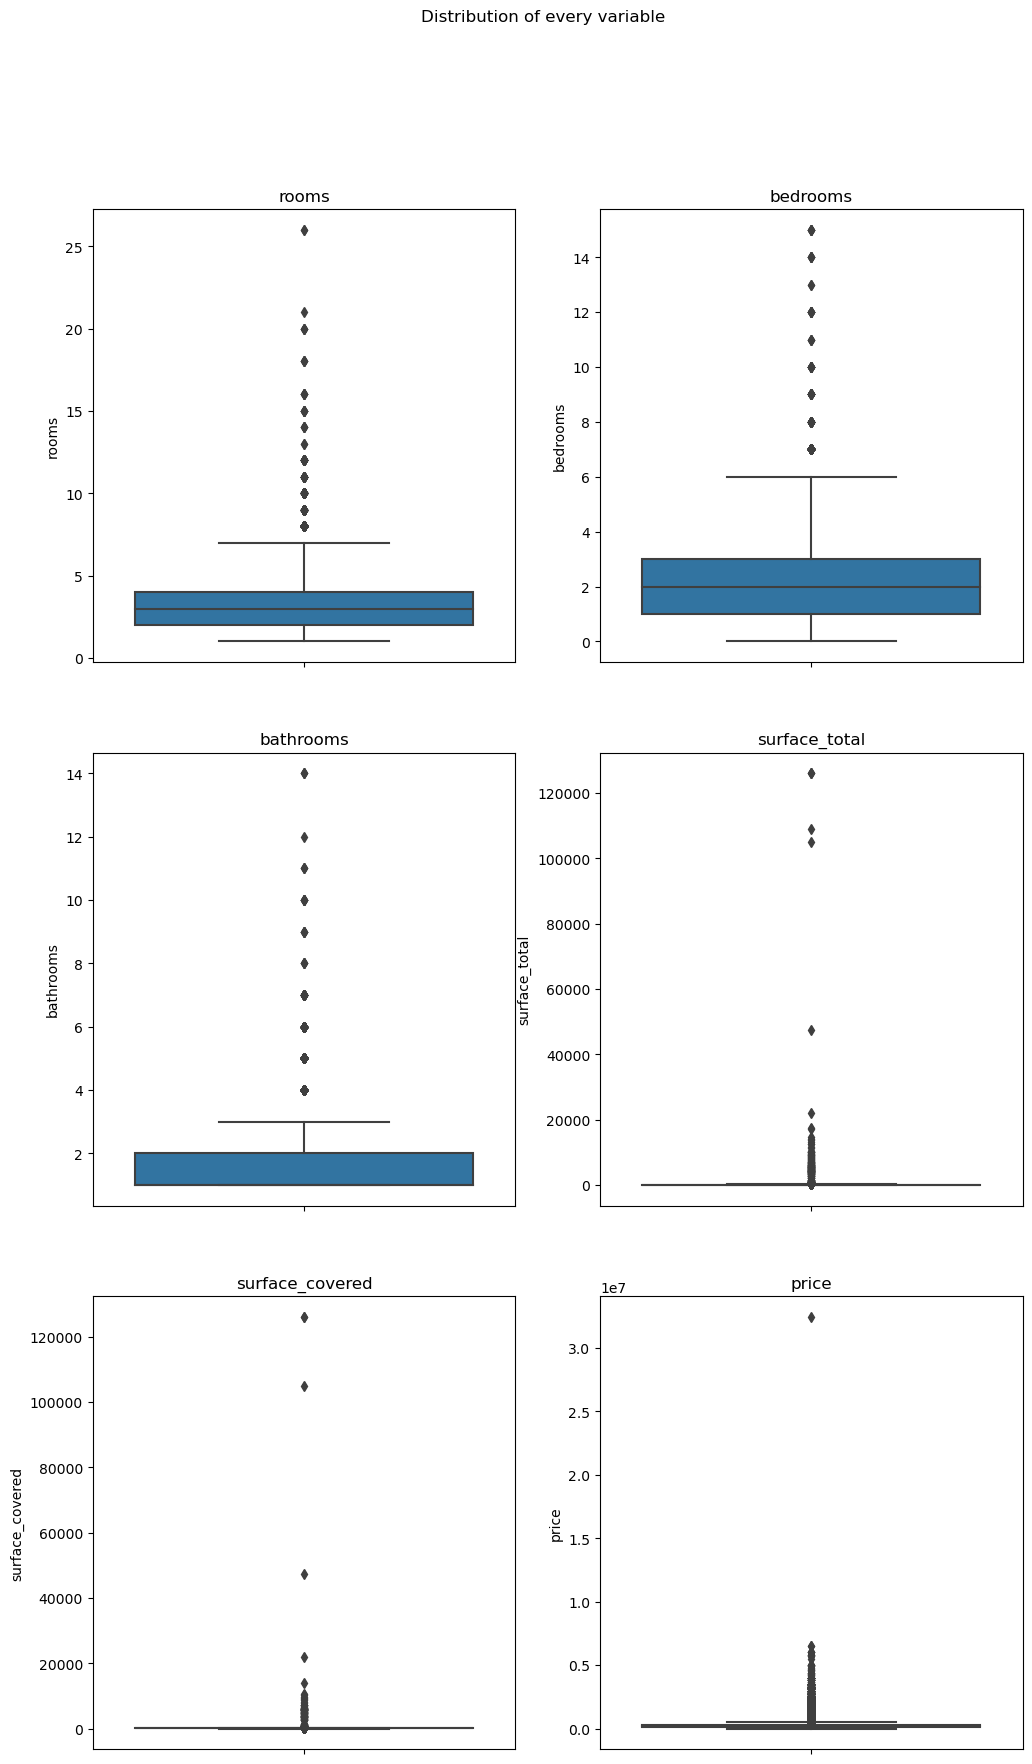

In [15]:
def plot_boxplots(dataframe):
    columns = dataframe.columns
    fig, axs = plt.subplots(3, 2, figsize = (12, 20))
    fig.suptitle("Distribution of every variable")
    counter = 0 # To get the index in the list of features
    for row in range(0,3):
        for column in range(0,2):
            column_name = columns[counter]
            # Plot process:
            sns.boxplot(ax = axs[row, column], data = dataframe, y = column_name)
            axs[row, column].set_title(column_name)
            counter += 1
    plt.show()
plot_boxplots(properati.iloc[:,2:])

In [16]:
properati.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,91485.000000,91485.000000,91485.000000,91485.000000,91485.000000,9.148500e+04
mean,2.964278,1.960278,1.560147,112.506120,94.149045,2.595003e+05
std,1.314704,1.072946,0.850040,931.705703,725.807649,3.222654e+05
min,1.000000,0.000000,1.000000,1.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,51.000000,46.000000,1.200000e+05
50%,3.000000,2.000000,1.000000,77.000000,68.000000,1.750000e+05
75%,4.000000,3.000000,2.000000,112.506120,112.506120,2.790000e+05
max,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


From the previous table we describe the numerical values. We can see that `price` has the higher standard deviation. So let's chop the 5% of both tails (to preserve more records):

In [17]:
def chop_quantiles_both_tails(df, variable, size_upper):
    df_copy = df.copy()
    df_chopped = df_copy[(df_copy[variable] < df_copy[variable].quantile(size_upper)) & (df_copy[variable] > df_copy[variable].quantile(1 - size_upper))]
    droped_rows = df_copy.shape[0] - df_chopped.shape[0]
    print(f"Where deleted {droped_rows} values a {droped_rows*100/df_copy.shape[0]:.2f}% of the data")
    print(f'The initial std for "{variable}" was: {np.std(df_copy.price):.2f}\nAfter droping the top 5% the std is: {np.std(df_chopped.price):.2f}')
    df_chopped.reset_index(drop = True, inplace = True)
    return df_chopped

In [18]:
properati_reduce = chop_quantiles_both_tails(properati, 'price', 0.95)

Where deleted 9151 values a 10.00% of the data
The initial std for "price" was: 322263.68
After droping the top 5% the std is: 120700.74


We have reduced more than half the std. Awesome!

In [19]:
notebook1 = 68237 
notebook2 = properati_reduce.shape[0]

print(f"From the previous notebook at the final stage of cleaning we had {notebook1} records. Now we have {notebook2} \
that means an increase of {notebook2 / notebook1 * 100:.2f}%, {notebook2 - notebook1} more records")

From the previous notebook at the final stage of cleaning we had 68237 records. Now we have 82334 that means an increase of 120.66%, 14097 more records


### Data standardization

#### Standardise

From the documentation of scikit-learn about [preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html) is possible to apply different transformation to the data. The most common is the `StardScaler`. Remember we must leave the dependent variable untransformed. There are 2 steps:

1. Slice the numerical features.
2. Apply the transformation to the sliced dataset.
3. Concat the transformed dataset with the price and categorical variables.

In [20]:
# 1 
properati_num = properati_reduce.filter(['rooms','bedrooms','bathrooms','surface_total','surface_covered'], axis=1)

In [21]:
# 2
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(properati_num)
data_scaled = pd.DataFrame(data_scaled, columns = properati_num.columns)

In [22]:
# 3
properati_st = pd.concat([data_scaled, properati_reduce['property_type'], properati_reduce['price']], axis=1)

#### One-Hot Encoding

Do you notice any difference from the dataset of the previous notebook? Yes, sure there is. We have more records and there are two categorical variables. What for? Because we are going to use encoding techniques no use this variables in the model.

The content of this blog was really useful to encode the categorical varibles: https://pbpython.com/categorical-encoding.html

First we need to convert the 'object' data type to 'category':

In [23]:
# Select object columns and cast to category
categoricas = properati_st.select_dtypes(include=['object']).columns
properati_st[categoricas] = properati_st[categoricas].astype('category')
properati_st.dtypes

rooms               float64
bedrooms            float64
bathrooms           float64
surface_total       float64
surface_covered     float64
property_type      category
price               float64
dtype: object

In [24]:
# Let's count the amount of categories
def count_categories(data):
    for i in data.select_dtypes(include=['category']).columns:
        print(i)
        print(data[i].unique())
        print('\n')
count_categories(properati_st)

property_type
['Departamento', 'PH', 'Casa']
Categories (3, object): ['Casa', 'Departamento', 'PH']




In [25]:
properatiML = pd.get_dummies (properati_st, columns = ['property_type'])

In [133]:
# sns.pairplot(properatiML)
# plt.show()

Good job! We already cleaned and improve the dataset. Let's play with machine learning 🚀

## Machine Learning

### ML Libraries and train test set

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import(
    make_scorer,
    r2_score as r2,
    mean_squared_error as mse,
    mean_absolute_error as mae)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

Let's separate the X variables and Y

In [27]:
X = properatiML.drop('price', axis = 1)
y = properatiML.price

Use the `train_test_split` function from scikit-learn:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 267)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(57633, 8) (57633,) (24701, 8) (24701,)


### Generalized functions to efficient ML

Because this is a remake, I'm doing my best by applying the DRY concept (Don't Repeat Yourself). We'll use the [results_p1.json](results_p1.json) file to compare the previous models (with no feature engineer and with less records) against an enhance data and new techniques to validate the model [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) and [Randomized Search Grid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and also fiting a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model (Please refer scikit-learn documentation to be aware of the process we're going to do).

I'll create a dictionary to store the results and create a `class` named `results_model` to automate the process of instantiate a model both by standard parameters or cross validation or randomized search cv.

Sounds challenging! But hands on labor 👷‍♂️

In [29]:
import json
with open("results_p1.json", 'r') as file:
    results_p1 = json.load(file)
results_p1 = pd.DataFrame(results_p1)

In [31]:
class ml_model:
    def __init__(self, model, x_train, x_test, y_train, y_test, model_name):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.model_name = model_name

    def init_regular_model(self):
        self.model.fit(self.x_train, self.y_train)
        y_train_pred = self.model.predict(self.x_train)
        y_test_pred = self.model.predict(self.x_test)
        mse_train = mse(self.y_train, y_train_pred)
        mse_test = mse(self.y_test, y_test_pred)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        return {
            "Model": self.model_name,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test,
            "Mean RMSE": np.mean([rmse_train, rmse_test])
            }

    def init_cv_model(self, folds, score = mse):
        scorer = make_scorer(score)
        cross_lineal = cross_val_score(self.model, X = self.x_train, y = self.y_train, cv = folds, scoring = scorer)
        # Root Square of the MSE
        fun = lambda x : np.sqrt(x)
        cross_lineal_rmse = fun(cross_lineal)
        # Return variables
        max_rmse = cross_lineal_rmse.max()
        min_rmse = cross_lineal_rmse.min()
        mean_rmse = cross_lineal_rmse.mean()
        std_rmse = cross_lineal_rmse.std()
        return {
            "Model" : self.model_name,
            "Max RMSE" : max_rmse ,
            "Min RMSE" : min_rmse ,
            "Mean RMSE" : mean_rmse ,
            "Std RMSE" : std_rmse
        }

    def init_rs_cv_model(self, parameters, n_iter, cv, score = mse):
        scorer = make_scorer(score)
        randomsearch = RandomizedSearchCV(
            estimator = self.model,
            param_distributions = parameters,
            n_iter = n_iter,
            cv = cv,
            verbose = 2,
            random_state = 267,
            n_jobs = -1,
            scoring = scorer)
        randomsearch.fit(self.x_train, self.y_train)

        # Let's instantiate the best model and predict the rmse
        best_estimator = randomsearch.best_estimator_
        y_train_pred = best_estimator.predict(self.x_train)
        y_test_pred = best_estimator.predict(self.x_test)
        rmse_train = np.sqrt(mse(y_train, y_train_pred))
        rmse_test = np.sqrt(mse(y_test, y_test_pred))
        result_best_estimator = {
            "Model": self.model_name,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test,
            "Mean RMSE": np.mean([rmse_train, rmse_test])
            }

        # Obtain the results from the CV process
        best_params = randomsearch.best_params_
        max_rmse = np.sqrt(randomsearch.cv_results_['mean_test_score'].max())
        min_rmse = np.sqrt(randomsearch.cv_results_['mean_test_score'].min())
        mean_rmse = np.sqrt(randomsearch.cv_results_['mean_test_score'].mean())
        std_rmse = np.sqrt(randomsearch.cv_results_['mean_test_score'].std())
        
        result_random_search = {
            "Model" : self.model_name + " random search results",
            "Best Params": best_params,
            "Max RMSE" : max_rmse ,
            "Min RMSE" : min_rmse ,
            "Mean RMSE" : mean_rmse ,
            "Std RMSE" : std_rmse
        }

        return result_best_estimator, result_random_search

### Linear Model (Benchmark)

#### Regular Linear Model

Let's our benchmark model:

In [32]:
linear = ml_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear p2")
results_linear = linear.init_regular_model()
results_linear

{'Model': 'Linear p2',
 'RMSE Train': 86839.70010932331,
 'RMSE Test': 86957.62368323101,
 'Mean RMSE': 86898.66189627716}

And compare with te previous notebook

In [33]:
results_p1.iloc[0,:]

Model               Linear
RMSE Train    64127.651901
RMSE test      63838.51668
Mean RMSE     63983.084291
Name: 0, dtype: object

Yes, these metrics are higher than the previous notebook. However, remember there are more records, which means more bias. Use these metrics as reference for the dataset.

#### CV Linear Model

In [36]:
linear_cv = ml_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear CV p2")
results_linear_cv = linear_cv.init_cv_model(100)
results_linear_cv

{'Model': 'Linear CV p2',
 'Max RMSE': 112149.67979061313,
 'Min RMSE': 76496.64026532456,
 'Mean RMSE': 87058.36230906232,
 'Std RMSE': 5199.627416824721}

We still have significant difference. We need to use other models. We don't implement the randomized search cv in linear models, because there are no parameters to adjust

### Decision tree regressor (DTR)

#### Regular DTR

From the previous notebook we can check where place the value of depth:

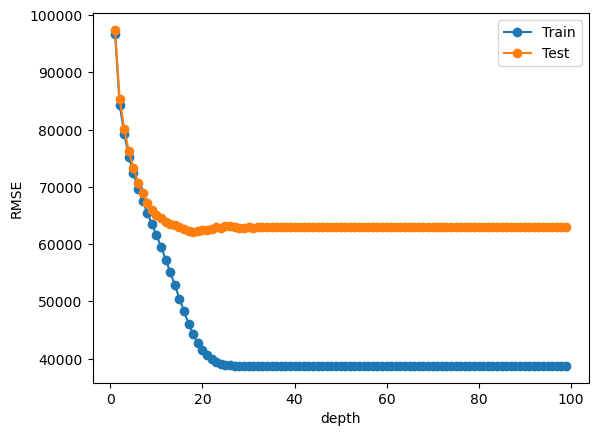

For train data the lowest RMSE was: 38737.820 with 33 depth
For test data the lowest RMSE was: 62070.999 with 18 depth


In [37]:
def evaluate_dtr():
    depth = list(np.arange(1,100))
    rmse_train_lst = []
    rmse_test_lst = []

    for i in depth:
        dtr = ml_model(DecisionTreeRegressor(max_depth=i, random_state=267), X_train, X_test, y_train, y_test, "DTR p2")
        results_dtr = dtr.init_regular_model() 
        rmse_train_lst.append(results_dtr.get("RMSE Train"))
        rmse_test_lst.append(results_dtr.get("RMSE Test"))

    plt.plot(depth, rmse_train_lst, 'o-', label='Train')
    plt.plot(depth, rmse_test_lst, 'o-', label='Test')
    plt.legend()
    plt.xlabel('depth')
    plt.ylabel('RMSE')
    plt.show()

    # Check the small value of RMSE in the list
    min_train = rmse_train_lst == np.min(rmse_train_lst)
    min_test = rmse_test_lst == np.min(rmse_test_lst)

    # Obtain the ammount of depth:
    n_train = np.where(min_train)[0][0] + 1
    n_test = np.where(min_test)[0][0] + 1

    print(f"For train data the lowest RMSE was: {np.min(rmse_train_lst):.3f} with {n_train} depth")
    print(f"For test data the lowest RMSE was: {np.min(rmse_test_lst):.3f} with {n_test} depth")
evaluate_dtr()

Now let's instantiate a model with a depth of 20:

In [38]:
dtr = ml_model(DecisionTreeRegressor(max_depth = 20, random_state = 267), X_train, X_test, y_train, y_test, "DTR p2")
results_dtr = dtr.init_regular_model()
results_dtr

{'Model': 'DTR p2',
 'RMSE Train': 41504.71839690115,
 'RMSE Test': 62465.176590432864,
 'Mean RMSE': 51984.94749366701}

In [39]:
results_p1.iloc[1,:]

Model                  KNN
RMSE Train    44368.028048
RMSE test     47629.817307
Mean RMSE     45998.922677
Name: 1, dtype: object

Compared from previous notebook looks higher, but compared to the linear p2, is an improve

#### CV DTR

In [40]:
dtr_cv = ml_model(DecisionTreeRegressor(max_depth = 20, random_state = 267), X_train, X_test, y_train, y_test, "DTR CV p2")
results_dtr_cv = dtr_cv.init_cv_model(100)
results_dtr_cv

{'Model': 'DTR CV p2',
 'Max RMSE': 73769.5766099649,
 'Min RMSE': 50999.61489098193,
 'Mean RMSE': 61187.6025235598,
 'Std RMSE': 4082.7079146098754}

#### Randomized Search CV DTR

We are going to use from `sklearn.model_selection` the function `RandomizedSearchCV`. This function requires a dictionary with the params to evaluate. Like this:

In [41]:
dtr_params = {"max_depth": range(15,33), # The depth of the tree (how many decisions)
             "max_features": range(2,100), # The number of features to consider when looking for the best split
             "min_samples_split": range(2,65), # The minimum number of samples required to split an internal nod
             "random_state": [42,1111,33]} # Controls the randomness of the estimator

From this definition of params we can verify that there will be:

```
17 `depths` x 97 `max_features` x 62 `min_samples_split` x 3 `random_state` = 306714
```
More than a third of million of probable combination of parameters, and remember we are going to use CV, so it's going to consume time...Let's resume by doing only 500 interactions on 10 folds

Now with parameters defined, let's run the algorith:

In [42]:
%%time
dtr_rs_cv = ml_model(DecisionTreeRegressor(), X_train, X_test, y_train, y_test, "DTR RS-CV p2")
results_dtr_rscv_best_params, results_dtr_rs_cv = dtr_rs_cv.init_rs_cv_model(dtr_params, n_iter = 500, cv = 10, score = mse)
print(results_dtr_rscv_best_params)
print("\n")
print(results_dtr_rs_cv)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
{'Model': 'DTR RS-CV p2', 'RMSE Train': 60203.33018054711, 'RMSE Test': 64078.41440271851, 'Mean RMSE': 62140.87229163281}


{'Model': 'DTR RS-CV p2 random search results', 'Best Params': {'random_state': 42, 'min_samples_split': 60, 'max_features': 3, 'max_depth': 15}, 'Max RMSE': 64444.95930195197, 'Min RMSE': 61437.130922190685, 'Mean RMSE': 62281.036377252276, 'Std RMSE': 8502.089844802256}
CPU times: total: 1min 17s
Wall time: 2min


We will discuss all the results at the end of the notebook. So, hold on 😁

### KNN

#### Regular KNN

From the previous notebook we can check where place the value of n_neighbors:

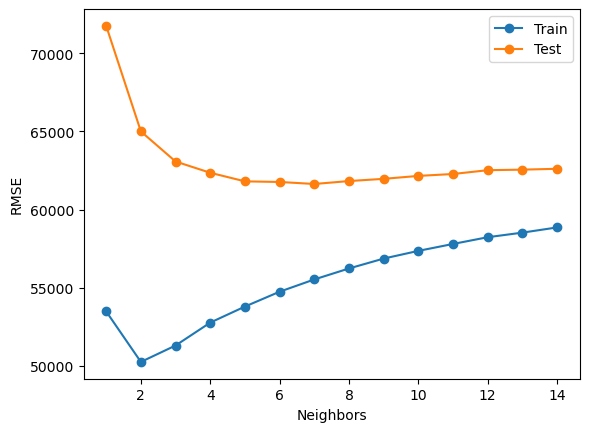

For train data the lowest RMSE was: 50238.530 with 2 neighbors
For test data the lowest RMSE was: 61636.468 with 7 neighbors


In [44]:
def evaluate_neighbors():
    neighbors = list(np.arange(1,15))
    rmse_train_lst = []
    rmse_test_lst = []

    for i in neighbors:
        knn = ml_model(KNeighborsRegressor(i), X_train, X_test, y_train, y_test, "KNN p2")
        results_knn = knn.init_regular_model()
        rmse_train_lst.append(results_knn.get("RMSE Train"))
        rmse_test_lst.append(results_knn.get("RMSE Test"))

    plt.plot(neighbors, rmse_train_lst, 'o-', label='Train')
    plt.plot(neighbors, rmse_test_lst, 'o-', label='Test')
    plt.legend()
    plt.xlabel('Neighbors')
    plt.ylabel('RMSE')
    plt.show()

    # Check the small value of RMSE in the list
    min_train = rmse_train_lst == np.min(rmse_train_lst)
    min_test = rmse_test_lst == np.min(rmse_test_lst)

    # Obtain the ammount of neighbors:
    n_train = np.where(min_train)[0][0] + 1
    n_test = np.where(min_test)[0][0] + 1

    print(f"For train data the lowest RMSE was: {np.min(rmse_train_lst):.3f} with {n_train} neighbors")
    print(f"For test data the lowest RMSE was: {np.min(rmse_test_lst):.3f} with {n_test} neighbors")
evaluate_neighbors()

Now let's instantiate a model with 5 neighbors as our benchmark:

In [46]:
knn = ml_model(KNeighborsRegressor(5), X_train, X_test, y_train, y_test, "KNN p2")
results_knn = knn.init_regular_model()
results_knn

{'Model': 'KNN p2',
 'RMSE Train': 53784.845537808535,
 'RMSE Test': 61805.05433428354,
 'Mean RMSE': 57794.94993604603}

#### CV KNN

In [47]:
%%time
knn_cv = ml_model(KNeighborsRegressor(5), X_train, X_test, y_train, y_test, "KNN CV p2")
results_knn_cv = knn_cv.init_cv_model(100)
results_knn_cv

CPU times: total: 18.7 s
Wall time: 18.8 s


{'Model': 'KNN CV p2',
 'Max RMSE': 70852.27952095757,
 'Min RMSE': 51505.446334681175,
 'Mean RMSE': 61912.33559240628,
 'Std RMSE': 3773.654958774649}

#### Randomized Search CV KNN

The parameters are extracted from [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html):

In [52]:
knn_params = {"n_neighbors": range(1, 11), # Number of neighbors to use by default for kneighbors queries
             "leaf_size": range(20,41) # Leaf size passed to BallTree or KDTree
             } 

In [55]:
%%time
knn_rs_cv = ml_model(KNeighborsRegressor(), X_train, X_test, y_train, y_test, "KNN RS-CV p2")
results_knn_rs_cv_best_params, results_knn_rs_cv = knn_rs_cv.init_rs_cv_model(knn_params, n_iter = 100, cv = 10, score = mse)
print(results_knn_rs_cv_best_params)
print("\n")
print(results_knn_rs_cv)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'Model': 'KNN RS-CV p2', 'RMSE Train': 53472.0923199982, 'RMSE Test': 71761.74350304328, 'Mean RMSE': 62616.91791152074}


{'Model': 'KNN RS-CV p2 random search results', 'Best Params': {'n_neighbors': 1, 'leaf_size': 40}, 'Max RMSE': 71680.13926933156, 'Min RMSE': 62358.94099495139, 'Mean RMSE': 63557.432870783145, 'Std RMSE': 17466.130216951376}
CPU times: total: 18.8 s
Wall time: 3min 42s


### Random Forest

#### Regular Random Forest

In [57]:
rfr = ml_model(RandomForestRegressor(max_depth = 20, random_state = 267), X_train, X_test, y_train, y_test, "Random Forest p2")
results_rfr = rfr.init_regular_model()
results_rfr

{'Model': 'Random Forest p2',
 'RMSE Train': 41702.82785555471,
 'RMSE Test': 55882.165987141576,
 'Mean RMSE': 48792.49692134814}

#### CV Random Forest

In [58]:
rfr_cv = ml_model(RandomForestRegressor(max_depth = 20, random_state = 267), X_train, X_test, y_train, y_test, "Random Forest CV p2")
results_rfr_cv = rfr_cv.init_cv_model(100)
results_rfr_cv

{'Model': 'Random Forest CV p2',
 'Max RMSE': 64074.89925779044,
 'Min RMSE': 46757.0455671248,
 'Mean RMSE': 55255.47375689736,
 'Std RMSE': 3381.077538921764}

#### Randomized Search CV Random Forest

Now that we know how to use the Randomized Search, it can be used with any machine learning model. So this must be simple.

In [59]:
rfr_parameters = {"max_depth" : range(15,33), # The maximum depth of the tre
              "n_estimators" : [10, 30, 50, 70, 100], # The number of trees in the forest
             "min_samples_split" : range(2,65), # The minimum number of samples required to split an internal node
             "random_state" : [42,1111,33]} # Controls the randomness of the estimator

From this definition of params we can verify that there will be:

```
17 `depths` x 5 `n_estimators` x 62 `min_samples_split` x 3 `random_state` = 15810
```

There are less than the DTR, let's do it by 300 iterations, the Random Forest requires more compute processing!

In [62]:
%%time
rfr_rs_cv = ml_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, "Random Forest RS-CV p2")
results_rfr_rs_cv_best_params, results_rfr_rs_cv = rfr_rs_cv.init_rs_cv_model(rfr_parameters, n_iter = 100, cv = 10, score = mse)
print(results_rfr_rs_cv_best_params)
print("\n")
print(results_rfr_rs_cv)

{'Model': 'Random Forest RS-CV p2', 'RMSE Train': 57209.6502604759, 'RMSE Test': 61095.635663264635, 'Mean RMSE': 59152.64296187027}


{'Model': 'Random Forest RS-CV p2 random search results', 'Best Params': {'random_state': 42, 'n_estimators': 10, 'min_samples_split': 60, 'max_depth': 19}, 'Max RMSE': 61391.27779910487, 'Min RMSE': 56101.42364158076, 'Mean RMSE': 59362.11134379757, 'Std RMSE': 13214.92067249729}
CPU times: total: 0 ns
Wall time: 0 ns


## Compare results

As a DRY mantra, create a function to join the results from regular, cv, and random search cv:

In [101]:
def select_type(type):
    if type == "regular":
        return ["Model", "RMSE Train", "RMSE Test", "Mean RMSE"]
    elif type == "cv":
        return ["Model", "Max RMSE", "Min RMSE", "Mean RMSE", "Std RMSE"]
    elif type == "rs-cv":
        return ["Model", "Best Params", "Max RMSE", "Min RMSE", "Mean RMSE", "Std RMSE"]
    else:
        print("You must select a valid type")

def summarize_results(type, **kwargs):
    columns = select_type(type)
    results = pd.DataFrame(columns = columns)
    for _, dictio in kwargs.items():
        input_result = {key : [element] for key, element in dictio.items()}
        element_df = pd.DataFrame.from_dict(input_result)
        results = pd.concat([results, element_df], axis = 0)
    return results

### Regular models

In [104]:
results_p2_regular = summarize_results("regular", linear = results_linear, dtr = results_dtr, knn = results_knn, rfr = results_rfr)
results_p2_regular

,Model,RMSE Train,RMSE Test,Mean RMSE
0,Linear p2,86839.700109,86957.623683,86898.661896
0,DTR p2,41504.718397,62465.176590,51984.947494
0,KNN p2,53784.845538,61805.054334,57794.949936
0,Random Forest p2,41702.827856,55882.165987,48792.496921


### CV models

In [105]:
results_p2_cv = summarize_results("cv", linear = results_linear_cv, dtr = results_dtr_cv, knn = results_knn_cv, rfr = results_rfr_cv)
results_p2_cv

,Model,Max RMSE,Min RMSE,Mean RMSE,Std RMSE
0,Linear CV p2,112149.679791,76496.640265,87058.362309,5199.627417
0,DTR CV p2,73769.576610,50999.614891,61187.602524,4082.707915
0,KNN CV p2,70852.279521,51505.446335,61912.335592,3773.654959
0,Random Forest CV p2,64074.899258,46757.045567,55255.473757,3381.077539


### Random Search CV models

In [107]:
results_p2_rs_cv = summarize_results("rs-cv", dtr = results_dtr_rs_cv, knn = results_knn_rs_cv, rfr = results_rfr_rs_cv)
results_p2_rs_cv

,Model,Best Params,Max RMSE,Min RMSE,Mean RMSE,Std RMSE
0,DTR RS-CV p2 random search results,"{'random_state': 42, 'min_samples_split': 60, ...",64444.959302,61437.130922,62281.036377,8502.089845
0,KNN RS-CV p2 random search results,"{'n_neighbors': 1, 'leaf_size': 40}",71680.139269,62358.940995,63557.432871,17466.130217
0,Random Forest RS-CV p2 random search results,"{'random_state': 42, 'n_estimators': 10, 'min_...",61391.277799,56101.423642,59362.111344,13214.920672


In [110]:
results_p1

,Model,RMSE Train,RMSE test,Mean RMSE
0,Linear,64127.651901,63838.516680,63983.084291
1,KNN,44368.028048,47629.817307,45998.922677
2,Tree Decision,32045.310232,48164.178912,40104.744572


Awesome!!! 👏

That was a challenge. We used the POO paradigm to solve this issue faster than we thought. I'll let you explore the results and conclude by yourself. Remember we did 3 kinds of evaluation over 4 models (except for linear): The regular fit over the model (experimenting with one parameter), the cross validation where there are different subsets of evaluation and random search with cross validation, which is a hyperparameter tuning plus cross validation.

For me the best model is the Random Forest in every scenario. Compared the results from previous notebook, although there are no improvements in raw metrics, when we inspect the overall dataset, where we perform a feature engineer, data imputation and standardize, we found more records, which mean more bias, thus, the metrics to evaluate the models (RMSE) will increase.

This is open source code, so you can use it, but remember to be etic and if is possibly, cite it.©